In [3]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import regex as re
from factorization import MatrixFactorization
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import random_split
import math
from collections import Counter
from matplotlib.ticker import MultipleLocator
from langdetect import detect, DetectorFactory, LangDetectException

In [4]:
reviews = pd.read_csv('data/reviews_cleaned.csv')

In [5]:
movies['genres'] = movies['genres'].apply(ast.literal_eval)

In [7]:
print("Total reviews:", reviews.shape[0])
print("Total movies:", movies.shape[0])
print()
print("Unique movies:", reviews.movie.nunique())
print("Unique users:", reviews.user.nunique())

Total reviews: 1802880
Total movies: 10700

Unique movies: 2504
Unique users: 102023


In [8]:
user_profiles = df_merged.groupby('user').agg({
    'rating': ['mean', 'count', 'std'],
    'liked': 'sum',
    'comments': 'sum',
    'likes': 'mean'
})

user_profiles.columns = ['avg_rating', 'review_count', 'rating_std', 'total_likes', 'total_comments', 'avg_review_likes']

In [9]:
user_profiles = user_profiles[user_profiles['review_count'] >= 5]
user_profiles = user_profiles[user_profiles['review_count'] <= 500]

In [10]:
# Get list of valid user IDs
valid_users = set(user_profiles.index)

# Keep only reviews from those users
reviews = reviews[reviews['user'].isin(valid_users)]

In [49]:
reviews.head(3)

,film_popularity,review_popularity,rating,liked,user,date,comments,movie,review,likes,release_year,avg rating,label,user_idx,movie_idx
0,1,1,10,1,b1mb1m,15 Jul 2023,199,barbie,s(he's) bro(ken),95535,2023,3.863179,2,0,0
19,1,20,2,0,suspiriaz,19 Jul 2023,508,barbie,LIBERAL FEMINISM THE MOVIE ❤️❤️❤️👩‍🦰🤗🤗🤗GUYS TH...,7941,2023,3.863179,2,1,0
21,1,22,7,1,neorapp,10 Jul 2023,12,barbie,barbie is a ken out of ken,7038,2023,3.863179,0,2,0


In [15]:
scaler = StandardScaler()
user_profiles_scaled = scaler.fit_transform(user_profiles.fillna(0))

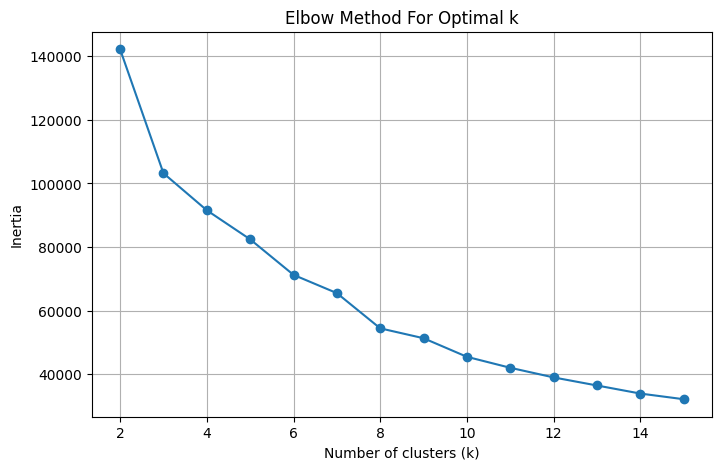

In [16]:
inertia = []
k_range = range(2, 16)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(user_profiles_scaled)
    inertia.append(kmeans.inertia_)

# Plot the elbow
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.show()

In [17]:
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(user_profiles_scaled)

KMeans(n_clusters=4, random_state=42)

In [18]:
user_profiles['label'] = kmeans.labels_

In [19]:
reviews['label'] = reviews['user'].map(user_profiles['label'])

In [20]:
reviews.head()

,film_popularity,review_popularity,rating,liked,user,date,comments,movie,review,likes,release_year,avg rating,label
0,1,1,10,1,b1mb1m,15 Jul 2023,199,barbie,s(he's) bro(ken),95535,2023,3.863179,2
19,1,20,2,0,suspiriaz,19 Jul 2023,508,barbie,LIBERAL FEMINISM THE MOVIE ❤️❤️❤️👩‍🦰🤗🤗🤗GUYS TH...,7941,2023,3.863179,2
21,1,22,7,1,neorapp,10 Jul 2023,12,barbie,barbie is a ken out of ken,7038,2023,3.863179,0
22,1,23,8,0,animationolgist,11 Jul 2023,6,barbie,Ken is the best disney princess,6640,2023,3.863179,1
23,1,24,9,0,rfeldman9,12 Jul 2023,408,barbie,BOY OH BOY! this movie might just break letter...,6418,2023,3.863179,2


In [35]:
def round_half_up(n):
    if n >= 0:
        return int(math.floor(n + 0.5))
    else:
        return int(math.ceil(n - 0.5))

def elements_in_iqr(arr, method='strict'):
    """
    Returns elements of the array that are within the IQR.

    Parameters:
        arr (array-like): Input array.
        method (str): 'strict' for Q1 to Q3 (inclusive),
                      'tukey' for 1.5*IQR outlier filtering.

    Returns:
        np.ndarray: Elements within the specified IQR range.
    """
    arr = np.asarray(arr)
    q1 = np.percentile(arr, 25)
    q3 = np.percentile(arr, 75)
    iqr = q3 - q1

    if method == 'strict':
        lower, upper = q1, q3
    elif method == 'tukey':
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
    else:
        raise ValueError("method must be 'strict' or 'tukey'")

    return arr[(arr >= lower) & (arr <= upper)]

In [23]:
X = reviews[['user', 'movie']].values  # numpy array
y = reviews['rating'].values

# Map user/movie string IDs to integers
user2idx = {u: i for i, u in enumerate(reviews['user'].unique())}
movie2idx = {m: i for i, m in enumerate(reviews['movie'].unique())}

idx2user = {i: u for u, i in user2idx.items()}
idx2movie = {i: m for m, i in movie2idx.items()}

# Replace string IDs with integer indices
reviews['user_idx'] = reviews['user'].map(user2idx)
reviews['movie_idx'] = reviews['movie'].map(movie2idx)

# Now create numeric numpy arrays
X = reviews[['user_idx', 'movie_idx']].values
y = reviews['rating'].values

# Convert to tensors
X_tensor = torch.tensor(X, dtype=torch.long)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Split data into train+val and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_tensor, y_tensor, test_size=0.2, random_state=42
)

# Split train+val into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, random_state=42
)

# Move tensors to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train = X_train.to(device)
y_train = y_train.to(device)

X_val = X_val.to(device)
y_val = y_val.to(device)

X_test = X_test.to(device)
y_test = y_test.to(device)

batch_size = 4096

# Helper function to create batches
def create_batches(X, y, batch_size):
    num_samples = X.shape[0]
    num_batches = (num_samples + batch_size - 1) // batch_size
    return [
        (X[i * batch_size : min((i + 1) * batch_size, num_samples)],
         y[i * batch_size : min((i + 1) * batch_size, num_samples)])
        for i in range(num_batches)
    ]

# Create batches for train, validation, and test sets
train_batches = create_batches(X_train, y_train, batch_size)
val_batches = create_batches(X_val, y_val, batch_size)
test_batches = create_batches(X_test, y_test, batch_size)

In [24]:
n_users = reviews.user.nunique()
n_movies = reviews.movie.nunique()

model = MatrixFactorization(n_users, n_movies, n_factors=256)

if torch.cuda.is_available():
   model = model.cuda()

loss_fn = nn.MSELoss()

optimizer = Adam(model.parameters(), lr=1e-3)

In [25]:
num_epochs = 256

best_val_loss = float('inf')
patience = 2
counter = 0

# ✅ Training loop
for epoch in tqdm(range(num_epochs)):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_batches:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = loss_fn(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_batches)

    # Validation step (no gradient needed)
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_batches:
            outputs = model(X_batch)
            loss = loss_fn(outputs, y_batch)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_batches)

    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {avg_train_loss:.4f}, Val loss: {avg_val_loss:.4f}")
    
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        # torch.save(model.state_dict(), "best_model.pth")
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered")
            break

  0%|▌                                                                                                                                                         | 1/256 [00:02<09:30,  2.24s/it]

Epoch 1/256 - Train loss: 32.8283, Val loss: 10.0252


  1%|█▏                                                                                                                                                        | 2/256 [00:02<05:14,  1.24s/it]

Epoch 2/256 - Train loss: 6.1867, Val loss: 4.8223


  1%|█▊                                                                                                                                                        | 3/256 [00:03<03:51,  1.09it/s]

Epoch 3/256 - Train loss: 4.0889, Val loss: 4.0572


  2%|██▍                                                                                                                                                       | 4/256 [00:03<03:13,  1.30it/s]

Epoch 4/256 - Train loss: 3.6434, Val loss: 3.8137


  2%|███                                                                                                                                                       | 5/256 [00:04<02:50,  1.47it/s]

Epoch 5/256 - Train loss: 3.4975, Val loss: 3.7221


  2%|███▌                                                                                                                                                      | 6/256 [00:04<02:37,  1.59it/s]

Epoch 6/256 - Train loss: 3.4425, Val loss: 3.6845


  3%|████▏                                                                                                                                                     | 7/256 [00:05<02:29,  1.67it/s]

Epoch 7/256 - Train loss: 3.4191, Val loss: 3.6693


  3%|████▊                                                                                                                                                     | 8/256 [00:05<02:23,  1.72it/s]

Epoch 8/256 - Train loss: 3.4067, Val loss: 3.6627


  4%|█████▍                                                                                                                                                    | 9/256 [00:06<02:19,  1.77it/s]

Epoch 9/256 - Train loss: 3.3975, Val loss: 3.6603


  4%|█████▉                                                                                                                                                   | 10/256 [00:07<02:16,  1.81it/s]

Epoch 10/256 - Train loss: 3.3879, Val loss: 3.6593


  4%|██████▌                                                                                                                                                  | 11/256 [00:07<02:14,  1.82it/s]

Epoch 11/256 - Train loss: 3.3757, Val loss: 3.6583


  5%|███████▏                                                                                                                                                 | 12/256 [00:08<02:12,  1.84it/s]

Epoch 12/256 - Train loss: 3.3591, Val loss: 3.6565


  5%|███████▊                                                                                                                                                 | 13/256 [00:08<02:11,  1.85it/s]

Epoch 13/256 - Train loss: 3.3361, Val loss: 3.6540


  5%|████████▎                                                                                                                                                | 14/256 [00:09<02:10,  1.86it/s]

Epoch 14/256 - Train loss: 3.3043, Val loss: 3.6485


  6%|████████▉                                                                                                                                                | 15/256 [00:09<02:09,  1.86it/s]

Epoch 15/256 - Train loss: 3.2605, Val loss: 3.6415


  6%|█████████▌                                                                                                                                               | 16/256 [00:10<02:08,  1.87it/s]

Epoch 16/256 - Train loss: 3.2009, Val loss: 3.6300


  7%|██████████▏                                                                                                                                              | 17/256 [00:10<02:08,  1.86it/s]

Epoch 17/256 - Train loss: 3.1210, Val loss: 3.6142


  7%|██████████▊                                                                                                                                              | 18/256 [00:11<02:07,  1.87it/s]

Epoch 18/256 - Train loss: 3.0161, Val loss: 3.5927


  7%|███████████▎                                                                                                                                             | 19/256 [00:11<02:07,  1.86it/s]

Epoch 19/256 - Train loss: 2.8821, Val loss: 3.5657


  8%|███████████▉                                                                                                                                             | 20/256 [00:12<02:06,  1.87it/s]

Epoch 20/256 - Train loss: 2.7170, Val loss: 3.5328


  8%|████████████▌                                                                                                                                            | 21/256 [00:12<02:05,  1.87it/s]

Epoch 21/256 - Train loss: 2.5223, Val loss: 3.4965


  9%|█████████████▏                                                                                                                                           | 22/256 [00:13<02:06,  1.85it/s]

Epoch 22/256 - Train loss: 2.3035, Val loss: 3.4592


  9%|█████████████▋                                                                                                                                           | 23/256 [00:14<02:05,  1.86it/s]

Epoch 23/256 - Train loss: 2.0697, Val loss: 3.4263


  9%|██████████████▎                                                                                                                                          | 24/256 [00:14<02:04,  1.87it/s]

Epoch 24/256 - Train loss: 1.8316, Val loss: 3.3993


 10%|██████████████▉                                                                                                                                          | 25/256 [00:15<02:03,  1.87it/s]

Epoch 25/256 - Train loss: 1.5991, Val loss: 3.3806


 10%|███████████████▌                                                                                                                                         | 26/256 [00:15<02:03,  1.87it/s]

Epoch 26/256 - Train loss: 1.3800, Val loss: 3.3705


 11%|████████████████▏                                                                                                                                        | 27/256 [00:16<02:02,  1.87it/s]

Epoch 27/256 - Train loss: 1.1800, Val loss: 3.3695


 11%|████████████████▋                                                                                                                                        | 28/256 [00:16<02:02,  1.86it/s]

Epoch 28/256 - Train loss: 1.0020, Val loss: 3.3757


 11%|████████████████▋                                                                                                                                        | 28/256 [00:17<02:20,  1.63it/s]

Epoch 29/256 - Train loss: 0.8470, Val loss: 3.3885
Early stopping triggered


In [26]:
true = []
pred = []

for X_batch, y_batch in test_batches:
    true += list(y_batch.cpu().detach().numpy())
    pred += list(model(X_batch).cpu().detach().numpy())

res = []

for p in pred:
    if p < 0:
        res.append(0)
    elif p > 10:
        res.append(10)
    else:
        res.append(p)
        
pred = res

results = list(zip(true, pred))

In [36]:
diffs = [round_half_up(r[0] - r[1]) for r in results]
iqr_diffs = elements_in_iqr(diffs)

In [37]:
np.std(diffs)

1.852901156025145

In [38]:
counts = Counter(diffs)
iqr_counts = Counter(iqr_diffs)

In [39]:
iqr_counts

Counter({0: 75665, 1: 56742, -1: 40430})

In [40]:
set(diffs)

{-10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10}

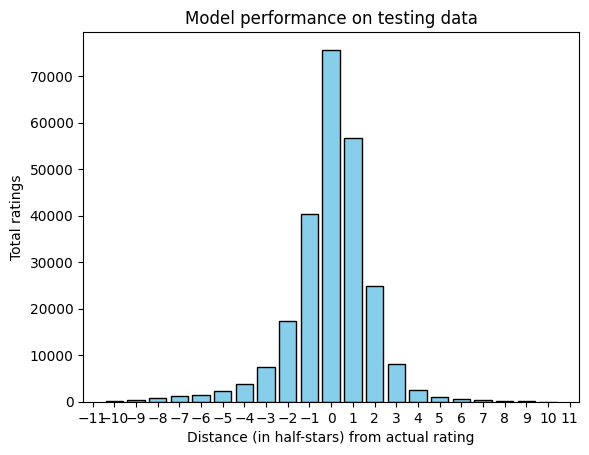

In [47]:
fig, ax = plt.subplots()

# Define bins so each bar centers on integers, e.g. for integers from min to max of diffs
bins = np.arange(min(diffs) - 0.5, max(diffs) + 1.5, 1)

# Plot histogram with bins, narrower bar width for gaps
counts, bins, patches = ax.hist(diffs, bins=bins, edgecolor='black', color='skyblue', align='mid', rwidth=0.8)

ax.xaxis.set_major_locator(MultipleLocator(1.0))
ax.set_title('Model performance on testing data')
ax.set_xlabel('Distance (in half-stars) from actual rating')
ax.set_ylabel('Total ratings')

plt.savefig('filename.png')
plt.show()

In [34]:
inertia = []
k_range = range(2, 16)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(user_weights)
    inertia.append(kmeans.inertia_)

# Plot the elbow
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.show()

NameError: name 'user_weights' is not defined

In [139]:
kmeans = KMeans(n_clusters=7, random_state=42)
kmeans.fit(user_weights)

KMeans(n_clusters=7, random_state=42)

In [140]:
kmeans.labels_.shape

(27780,)

In [141]:
user_profiles['label'] = kmeans.labels_
reviews['label'] = reviews['user'].map(user_profiles['label'])
df_merged['label'] = df_merged['user'].map(user_profiles['label'])